In [9]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr')

# Add the root directory of this repository
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [10]:
from misc import calc_avg_cov

## Checking Conditions

In [11]:
n_features = 500

# Generate the covariance matrices used in our study
# Block sizes
block_sizes = [25, 50, 100]

# Block correlation
correlation = [0, 0.08891397, 0.15811388, 0.28117066, 0.5]

# Exponential length scales
L = [10, 25, 50, 100]

cov_list, _ = get_cov_list(n_features, 60, correlation, block_sizes, L, n_supplement = 20)

cov_params = [{'correlation' : t[0], 'block_size' : t[1], 'L' : t[2], 't': t[3]} for t in cov_list]

sigma = []

for params in cov_params:
    sigma.append(gen_covariance(n_features, **params))

In [17]:
# For each covariance matrix, sample 100 design matrices and calculate the average condition number 
# that results
n_reps = 100
n_samples = 4 * n_features
condition_numbers = np.zeros(len(sigma))
cnum_var = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    cnums = np.zeros(n_reps)
    for i in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        cnums[i] = np.linalg.cond(X)
    
    condition_numbers[j] = np.mean(cnums)
    cnum_var[j] = np.std(cnums)    
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [12]:
# Calculate the average covariance
avg_cov = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    avg_cov[j] = np.mean(s)

In [24]:
# Calculate the rank of design matrices:
n_reps = 100
n_samples = 4 * n_features
ranks =np.zeros(len(sigma))
rank_var = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    rs = np.zeros(n_reps)
    for i in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        rs[i] = np.linalg.matrix_rank(X)
    
    ranks[j] = np.mean(rs)
    rank_var[j] = np.std(rs)    
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


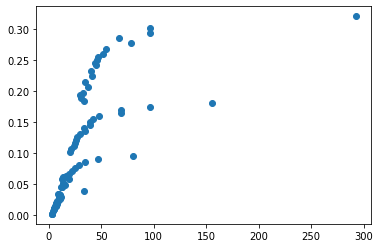

In [15]:
plt.plot(condition_numbers, avg_cov, 'o')

In [12]:
def validate_irrepresentible(X, support):
    # Validate whether the design matrix satisfies the irrepresentible condition, assuming that the
    # sign of all coefficients are positive
    
    n, p = X.shape
    q = np.count_nonzero(support)
    
    # Restrict the data to the support and the component lacking the support
    X1 = X[:, support]
    X2 = X[:, np.invert(support)]
    
    # calculate the quadrants of the grammian
    C11 = 1/n * X1.T @ X1
    C12 = 1/n * X1.T @ X2
    C21 = 1/n * X2.T @ X1
    C22 = 1/n * X2.T @ X2
        
    if np.any([0 in C11.shape, 0 in C12.shape, 0 in C21.shape, 0 in C22.shape]):
        return np.nan
    else:
        # Inequality needs to hold element-wise
        return np.all(np.sum(np.abs(C21 @ np.linalg.inv(C11)), axis= 1) < np.ones(p - q))

In [15]:
# Also relevant here: Sparsity and block structure
n_samples = 4 * n_features
sparsity = np.logspace(np.log10(0.02), 0, 15)
block_size = [20, 50, 100, 500]
n_reps = 10
irrepresentible = np.zeros((len(sigma), n_reps, sparsity.size, len(block_size)))
for i1, s in enumerate(sigma):    
    t0 = time.time()
    for j in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        for i2, spar in enumerate(sparsity):
            for i3, bs in enumerate(block_size):
                beta = gen_beta2(n_features = n_features, block_size = bs, sparsity = spar)
                support = beta.astype(bool).ravel()
                irrepresentible[i1, j, i2, i3] = validate_irrepresentible(X, support)
        print('(i1, j) = (%d, %d), Time = %f' % (i1, j, time.time() - t0))

(i1, j) = (0, 0), Time = 0.922284
(i1, j) = (0, 1), Time = 1.866060
(i1, j) = (0, 2), Time = 2.761881
(i1, j) = (0, 3), Time = 3.654287
(i1, j) = (0, 4), Time = 4.586295
(i1, j) = (0, 5), Time = 5.524209
(i1, j) = (0, 6), Time = 6.516158
(i1, j) = (0, 7), Time = 7.490102
(i1, j) = (0, 8), Time = 8.645663
(i1, j) = (0, 9), Time = 9.630005
(i1, j) = (1, 0), Time = 0.897608
(i1, j) = (1, 1), Time = 1.881890
(i1, j) = (1, 2), Time = 2.914426
(i1, j) = (1, 3), Time = 4.082561
(i1, j) = (1, 4), Time = 5.031265
(i1, j) = (1, 5), Time = 5.949920
(i1, j) = (1, 6), Time = 6.846019
(i1, j) = (1, 7), Time = 7.721531
(i1, j) = (1, 8), Time = 8.594250
(i1, j) = (1, 9), Time = 9.481899
(i1, j) = (2, 0), Time = 0.954292
(i1, j) = (2, 1), Time = 1.966832
(i1, j) = (2, 2), Time = 2.878440
(i1, j) = (2, 3), Time = 3.775696
(i1, j) = (2, 4), Time = 4.676060
(i1, j) = (2, 5), Time = 5.568115
(i1, j) = (2, 6), Time = 6.451686
(i1, j) = (2, 7), Time = 7.347374
(i1, j) = (2, 8), Time = 8.240308
(i1, j) = (2, 

(i1, j) = (23, 7), Time = 8.279527
(i1, j) = (23, 8), Time = 9.289023
(i1, j) = (23, 9), Time = 10.244839
(i1, j) = (24, 0), Time = 0.940437
(i1, j) = (24, 1), Time = 1.957311
(i1, j) = (24, 2), Time = 2.928289
(i1, j) = (24, 3), Time = 3.891917
(i1, j) = (24, 4), Time = 4.857872
(i1, j) = (24, 5), Time = 5.771293
(i1, j) = (24, 6), Time = 6.672675
(i1, j) = (24, 7), Time = 7.639586
(i1, j) = (24, 8), Time = 8.570373
(i1, j) = (24, 9), Time = 9.526527
(i1, j) = (25, 0), Time = 0.979341
(i1, j) = (25, 1), Time = 1.901900
(i1, j) = (25, 2), Time = 2.822510
(i1, j) = (25, 3), Time = 3.762602
(i1, j) = (25, 4), Time = 4.695109
(i1, j) = (25, 5), Time = 5.609955
(i1, j) = (25, 6), Time = 6.615375
(i1, j) = (25, 7), Time = 7.615482
(i1, j) = (25, 8), Time = 8.528073
(i1, j) = (25, 9), Time = 9.495331
(i1, j) = (26, 0), Time = 0.911013
(i1, j) = (26, 1), Time = 1.941208
(i1, j) = (26, 2), Time = 2.932043
(i1, j) = (26, 3), Time = 3.919568
(i1, j) = (26, 4), Time = 5.097217
(i1, j) = (26, 5), 

(i1, j) = (47, 1), Time = 2.238993
(i1, j) = (47, 2), Time = 3.309868
(i1, j) = (47, 3), Time = 4.471855
(i1, j) = (47, 4), Time = 5.470462
(i1, j) = (47, 5), Time = 6.413557
(i1, j) = (47, 6), Time = 7.565518
(i1, j) = (47, 7), Time = 8.549080
(i1, j) = (47, 8), Time = 9.539710
(i1, j) = (47, 9), Time = 10.558434
(i1, j) = (48, 0), Time = 1.194457
(i1, j) = (48, 1), Time = 2.294127
(i1, j) = (48, 2), Time = 3.357603
(i1, j) = (48, 3), Time = 4.389246
(i1, j) = (48, 4), Time = 5.986281
(i1, j) = (48, 5), Time = 8.245686
(i1, j) = (48, 6), Time = 9.632122
(i1, j) = (48, 7), Time = 10.792379
(i1, j) = (48, 8), Time = 12.328870
(i1, j) = (48, 9), Time = 13.658140
(i1, j) = (49, 0), Time = 1.344333
(i1, j) = (49, 1), Time = 2.795850
(i1, j) = (49, 2), Time = 3.955802
(i1, j) = (49, 3), Time = 5.010022
(i1, j) = (49, 4), Time = 6.164724
(i1, j) = (49, 5), Time = 7.298991
(i1, j) = (49, 6), Time = 8.400468
(i1, j) = (49, 7), Time = 9.704714
(i1, j) = (49, 8), Time = 10.961569
(i1, j) = (49, 

(i1, j) = (70, 5), Time = 5.347741
(i1, j) = (70, 6), Time = 6.225383
(i1, j) = (70, 7), Time = 7.110897
(i1, j) = (70, 8), Time = 7.994591
(i1, j) = (70, 9), Time = 8.878424
(i1, j) = (71, 0), Time = 0.892540
(i1, j) = (71, 1), Time = 1.770144
(i1, j) = (71, 2), Time = 2.647348
(i1, j) = (71, 3), Time = 3.530274
(i1, j) = (71, 4), Time = 4.400448
(i1, j) = (71, 5), Time = 5.284236
(i1, j) = (71, 6), Time = 6.173740
(i1, j) = (71, 7), Time = 7.059506
(i1, j) = (71, 8), Time = 7.929520
(i1, j) = (71, 9), Time = 8.821252
(i1, j) = (72, 0), Time = 0.895049
(i1, j) = (72, 1), Time = 1.787791
(i1, j) = (72, 2), Time = 2.656007
(i1, j) = (72, 3), Time = 3.536889
(i1, j) = (72, 4), Time = 4.415410
(i1, j) = (72, 5), Time = 5.306819
(i1, j) = (72, 6), Time = 6.212850
(i1, j) = (72, 7), Time = 7.087177
(i1, j) = (72, 8), Time = 7.962803
(i1, j) = (72, 9), Time = 8.845475
(i1, j) = (73, 0), Time = 0.879324
(i1, j) = (73, 1), Time = 1.884715
(i1, j) = (73, 2), Time = 2.788099
(i1, j) = (73, 3), T

In [50]:
# Need to save away the data above, preserving labels of covariance params, sparsity, block size.
import pickle

In [52]:
# First, the condition numbers:
with open('cond_nums.dat', 'wb') as f:
    f.write(pickle.dumps(cov_params))
    f.write(pickle.dumps(condition_numbers))
    f.write(pickle.dumps(cnum_var))

In [53]:
# Next, the verification of the irrepresentable condition
with open('irrep_cond.dat', 'wb') as f:
    f.write(pickle.dumps('(cov_params, reps, sparsity, block_size)'))
    f.write(pickle.dumps({'cov_params': cov_params, 'sparsity': sparsity, 'block_size': block_size}))
    f.write(pickle.dumps(irrepresentible))

In [2]:
import pickle

## Exploring validated conditions

In [3]:
# Open up the irrep_cond checks
with open('irrep_cond.dat', 'rb') as f:
    checks = pickle.load(f)